In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
#import mne
import os
import seaborn as sns
import copy
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from environment_info import *
from patient_info import *
#import environment_info

# now we have data_dir, scripts_dir, and root_dir

sns.set()

In [4]:
def conv_montage(file):
    montage_array = (''.join([chr(i) for i in file['Montage']['MontageString']])).split(' ')
    return montage_array

def get_num_chans(file):
    num_chans = int(np.sum(list(file['Montage']['Montage'])))
    return num_chans

def convert_power_data(f,num_chans):
    labels_data = list(f['power'])
    freq_names = list(f['power'][labels_data[0]])
    power_feat_names = freq_names
    power_trials = np.squeeze(([[f['power'][interest][interest_freq][0:num_chans] for interest_freq in  f['power'][interest]] for interest in labels_data]))
    return power_trials, power_feat_names
    
def convert_connectivity_data(file,num_chans):
    labels_data = list(f['connectivity'])
    connectivity_names = list(f['connectivity'][labels_data[0]])
    freq_names = list(f['connectivity'][labels_data[0]][connectivity_names[0]])

    corr_feat_name = list(f['connectivity'][labels_data[0]][connectivity_names[0]])
    plv_feat_name = list(f['connectivity'][labels_data[0]][connectivity_names[1]])
    psi_feat_name = list(f['connectivity'][labels_data[0]][connectivity_names[2]])

    connectivity_trials_corr = np.squeeze([[[f['connectivity'][interest]['corrs'][interest_meas][0:num_chans,0:num_chans]] for interest_meas in f['connectivity'][interest]['corrs']] for interest in labels_data])
    connectivity_trials_plv = np.squeeze([[[f['connectivity'][interest]['corrs'][interest_meas][0:num_chans,0:num_chans]] for interest_meas in f['connectivity'][interest]['plv']] for interest in labels_data])
    connectivity_trials_psi = np.squeeze([[[f['connectivity'][interest]['psi'][interest_meas][0:num_chans,0:num_chans]] for interest_meas in f['connectivity'][interest]['psi']] for interest in labels_data])

    return connectivity_trials_corr, corr_feat_name, connectivity_trials_plv, plv_feat_name, connectivity_trials_psi, psi_feat_name

def one_hot_encode(electrodes,num_chans):
    
    one_hot_vec = np.zeros((num_chans,1))
    one_hot_vec[electrodes] = 1
    one_hot_vec[one_hot_vec==0] = -1 
    
    return one_hot_vec

In [56]:
# iterate over all patients



for ind_int in np.arange(1,len(patient_names)):

    path_int = os.path.join(data_dir,patient_names[ind_int]+data_file_suffix)

    # load in the file
    f = h5py.File(path_int,'r')

    # patient name
    patient_name = patient_names[ind_int]

    # get the number of channels
    num_chans = get_num_chans(f)

    # account for 3 not complete montages 
    if patient_name in ['fca96e','78283a', '294e1c']:
        num_chans = 64 

    # seizure electrodes 
    seizure_elec = one_hot_encode(seizure_electrodes[ind_int],num_chans)

    # generate a random sequence for the number of channels 

    num_blocks = len(f['connectivity'])

    # generate a random sequence
    num_windows_random = np.arange(num_blocks)
    random_seq_arr = np.array([np.random.permutation(num_chans) for i in num_windows_random])

    # randomly shuffle test labels
    seizure_elec_shuff = np.repeat(seizure_elec,num_blocks,axis=1).T
    seizure_elec_shuff = np.array([seizure_elec_shuff[i,random_seq_arr[i,:]] for i in np.arange(num_blocks)])
    seizure_elec_shuff = np.squeeze(np.reshape(seizure_elec_shuff,(1,-1)))

    
    # get the montage
    montage = conv_montage(f) 

    p_t,p_n = convert_power_data(f,num_chans)
    c_corr_t,c_corr_n,c_plv_t,c_plv_n,c_psi_t,c_psi_n = convert_connectivity_data(f,num_chans)

    p_t_t = np.transpose(p_t,(0,2,1))

    random_seq_data = np.reshape(np.repeat(random_seq_arr,p_t_t.shape[2],axis=1),np.array(p_t_t.shape))

    shuff_data = zeros((p_t_t.shape))

    for i in np.arange(p_t_t.shape[0]):
        shuff_data[i,:] = p_t_t[i,random_seq_arr[i]]
        
    if ind_int == 1:
        shuff_data_all = shuff_data.reshape((shuff_data.shape[0]*shuff_data.shape[1],shuff_data.shape[2]))
        seizure_elec_all = seizure_elec_shuff
        
    shuff_data = shuff_data.reshape((shuff_data.shape[0]*shuff_data.shape[1],shuff_data.shape[2]))

    shuff_data_all = np.vstack((shuff_data_all,shuff_data))
    seizure_elec_all = np.hstack((seizure_elec_all,seizure_elec_shuff))

(240, 12)
(240, 12)
(240,)
(240,)


(480, 12)
(192, 12)
(480,)
(192,)


(672, 12)
(192, 12)
(672,)
(192,)


(864, 12)
(378, 12)
(864,)
(378,)


(1242, 12)
(258, 12)
(1242,)
(258,)


(1500, 12)
(240, 12)
(1500,)
(240,)


(1740, 12)
(192, 12)
(1740,)
(192,)




In [65]:
n_leave = 192
train_data = shuff_data_all[0:n_leave,:]
test_data = shuff_data_all[n_leave:,:] 
train_labels = seizure_elec_all[0:n_leave]
test_labels = seizure_elec_all[n_leave:]


# demean the data 
train_data_average = np.repeat(np.array([(np.mean(train_data,axis=0))]).T,train_data.shape[0],axis=1).T
test_data_average = np.repeat(np.array([(np.mean(train_data,axis=0))]).T,test_data.shape[0],axis=1).T

train_data_std = np.repeat(np.array([(np.std(train_data,axis=0))]).T,train_data.shape[0],axis=1).T
test_data_std = np.repeat(np.array([(np.std(train_data,axis=0))]).T,test_data.shape[0],axis=1).T

# mean subtract and normalize 
train_data = (train_data - train_data_average)/train_data_std
test_data = (test_data - test_data_average)/test_data_std

In [68]:
norm_val = 1

LR_mod_l1 = LogisticRegression(C=norm_val,penalty='l1',tol=0.01)
LR_mod_l1.fit(train_data,train_labels)
LR_mod_l1_coeff = LR_mod_l1.coef_.ravel()
sparsity_LR_l1 = np.mean(LR_mod_l1_coeff == 0) * 100
print("C=%.2f" % norm_val)
print("Sparsity with L1 penalty: %.2f%%" % sparsity_LR_l1)
print("train score with L1 penalty: %.4f" % LR_mod_l1.score(train_data,train_labels))
print("test score with L1 penalty: %.4f" % LR_mod_l1.score(test_data,test_labels))


LR_mod_l2 = LogisticRegression(C=norm_val,penalty='l2',tol=0.01)
LR_mod_l2.fit(train_data,train_labels)
LR_mod_l2_coeff = LR_mod_l2.coef_.ravel()
sparsity_LR_l2 = np.mean(LR_mod_l2_coeff == 0) * 100
print("C=%.2f" % norm_val)
print("Sparsity with L2 penalty: %.2f%%" % sparsity_LR_l2)
print("train score with L2 penalty: %.4f" % LR_mod_l2.score(train_data_stack_average,train_labels_stack))
print("test score with L1 penalty: %.4f" % LR_mod_l1.score(test_data_stack_average,test_labels_stack))


plt.figure()
plt.imshow(np.abs(LR_mod_l1_coeff.reshape(1, 12)), interpolation='nearest',
               cmap='binary', vmax=1, vmin=0)
plt.figure()
plt.imshow(np.abs(LR_mod_l2_coeff.reshape(1, 12)), interpolation='nearest',
               cmap='binary', vmax=1, vmin=0)

C=1.00
Sparsity with L1 penalty: 33.33%
train score with L1 penalty: 0.8542
test score with L1 penalty: 0.7580
C=1.00
Sparsity with L2 penalty: 0.00%


ValueError: Found input variables with inconsistent numbers of samples: [2, 128]

In [67]:
svm_mod = svm.SVC(kernel='rbf')
svm_mod.fit(train_data,train_labels)
svm_train_score = svm_mod.score(train_data,train_labels)
svm_test_score = svm_mod.score(test_data,test_labels)
print('train score {}'.format(svm_train_score))
print('test score {}'.format(svm_test_score))

train score 0.8645833333333334
test score 0.8701149425287357


### raw signal

In [315]:
labels_data = list(f['data'].keys())
signal_mat = np.array([f['data'][interest][:] for interest in labels_data])

In [316]:
signal_mat.shape

(3, 106, 312000)

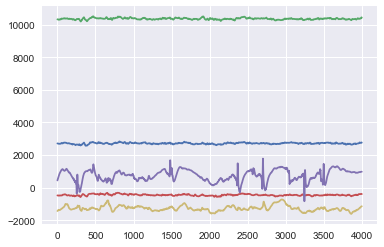

In [317]:
plt.figure()
trial = 1
channel = 60

plt.plot(np.squeeze(signal_mat[trial][channel][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+1][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+3][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+5][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+10][50000:54000]))

In [ ]:
#https://github.com/emanuele/convert_matlab73_hdf5

In [ ]:
seizure_electrodes = [
[1,2,3,4,5,1,4,3], # not done at all, montage issue
[7,8,15,16,29,30,34,35,44,45,54,55,63,64,65], # done 
    [33, 41, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64], # NOT done, but done on grid
[8,16,24], # NOT done, but done on grid
[70,74,75,76,77,86,87,92,93,94], # done 
[17,18,25,26,27,28,29,35,36,37,74,82],# done
[20,21,28,29,36,68], # maybe done 
[13, 21, 43, 44, 50, 53] # not DONE, but done on grid
]

In [ ]:
np.array(seizure_electrodes[1])-1

In [ ]:
len(seizure_electrodes)

### scratch section

In [ ]:
# implement the gradient method 
def gradient_method(X,y,X_test,y_test,lambda_val):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 0
    #step_size = 1e-3
    #step_size = 3e-2
    step_size = 1e-3
    criteria_conv = 0.000004

    
    # do one run through first after being initialized to zero 
    w = np.zeros((np.shape(X)[1],))
    b = 0

    n = np.shape(X)[0]
    n_features = np.shape(X)[1]
    n_test = np.shape(X_test)[0]
    
    cost_mu = 1+np.exp(-y*(b+np.dot(X,w))) 
    
    # calculate cost function on training
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    print('the value of j train is {}'.format(j_train))

    ####### testing part
    cost_mu_test = 1+np.exp(-y_test*(b+np.dot(X_test,w)))

    j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)

    ###       
    w_vec.append(w)
    b_vec.append(b)

    #### classification
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]

    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n_test

    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    w_old = copy.copy(w)
    b_old = copy.copy(b)
    
    while not_conv:
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 

        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/n)*np.sum(-y*(1-mu_vec))

        # 
        w = w_old - step_size*g_w
        b = b_old - step_size*g_b

        w_vec.append(w)
        b_vec.append(b)
        
        cost_mu = 1+np.exp(-y*(b+np.dot(X,w)))
        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part

        mu_vec = 1/(1+np.exp(-y_test*(b+np.dot(X_test,w)))) 
        cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classification
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)
        
        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)
        
        #w = np.array(w)
        w_old = copy.copy(w)
        b_old = copy.copy(b)

        # check convergence
        if ((1/n_features)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False

        else:
            not_conv = True
            k += 1

        print('the value of j train is {}'.format(j_train))

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec

# plot the cost fucntion and misclassification error 
def plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,titl_1):
    
    # plot the cost function vs. iteration
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec[10:],j_train_vec[10:],label='training')
    plt.plot(k_vec[10:],j_test_vec[10:],label='testing')
    plt.xlabel('iteration number')
    plt.ylabel('cost function')
    plt.title(titl_1 + 'Cost function vs. iteration')
    plt.legend()
    index = np.argmin(j_train_vec)
    k_best = k_vec[index]
    w_best = w_vec[index]
    titl_1_save = titl_1[:-2]
    titl_1_save = titl_1_save.replace(" ","_")
    #plt.savefig(titl_1_save + 'cost_func')

    # plot the misclassification error vs. iteration 
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec[10:],train_classify_vec[10:],label='training data')
    plt.plot(k_vec[10:],test_classify_vec[10:],label='test data')
    plt.xlabel('iteration number')
    plt.ylabel('misclassification error')
    plt.title(titl_1 + 'Misclassification error vs. iteration number')
    plt.legend()
    #plt.savefig(titl_1_save + 'mis_class_error')


In [ ]:
lambda_val = 10**-1
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = gradient_method(train_data_stack,train_labels_stack,test_data_stack,test_labels_stack,lambda_val)

In [ ]:
j_test_vec

In [ ]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Gradient Descent - \n')

In [ ]:
w_vec[-1]
plt.plot(w_vec[-1],'o')